In [0]:
#NACHISS :-
#import nltk
# nltk.download('punkt') 
#pip install mpld3 
# pip3 install git+https://github.com/sushinoya/ggpy

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
import sys  
from imp import reload

reload(sys)  
#sys.setdefaultencoding('utf8')

<module 'sys' (built-in)>

In [14]:
import sys
reload(sys)  
#sys.setdefaultencoding('Cp1252')

<module 'sys' (built-in)>

In [0]:
import mpld3
mpld3.enable_notebook()

In [0]:
import sys
sys.path.append('/content/drive/GoogleDrive_Utils/')

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [0]:
import tensorflow as tf 
import numpy as np 
import pandas as pd 
import nltk
import math
import random
from sklearn.svm import SVC
from sklearn.utils import shuffle
#from load_imdb_data import load_imdb_data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np 
import matplotlib.pyplot as plt 
np.random.seed(0)

In [0]:
data = open("/content/drive/NLP_bootcamp/Data/intent_data.txt").readlines()

In [0]:
data = data[1:]

In [0]:
sentence = []
labels = []

for item in data:
    temp = item.split('   ')
    sentence.append(temp[0].strip())
    labels.append(temp[1].strip().replace("\n", ''))

In [0]:
#sentence = [line.decode('utf-8').strip() for line in sentence]
sentence = [line.strip() for line in sentence]

In [23]:
sentence[:2], labels[:2]

(['I must look like a right weirdo .',
  "I really don't want to get up and get dressed for work"],
 ['non-intent', 'trifle'])

In [0]:
df = pd.DataFrame()
df['review'] = sentence
df['label'] = labels

In [0]:
df = df[df['label'].isin(['food', 'travel', 'career'])]

In [0]:
df.reset_index(drop=True, inplace=True)

In [27]:
df.head()

,review,label
0,I really want a hot dog . My co-workers went t...,food
1,"I wanna go to the beach , but ... Where is the...",travel
2,I really look forward to Egypt next week ! Its...,travel
3,I should buy more oatmeal cookies .. I just at...,food
4,"I want pancakes , should I make some ???",food


In [0]:
def processDocs(documents, vocab_size=5000):
    """
    This functions takes in a collection of documents and generates a vocabulary based on the size given in input. 
    It returns a representation for each document in the list of input documents. 
    """
    vocab = {} 
    doc_id = 0 
    doc_ids = []
    
    for doc in documents:
        doc_ids.append(doc_id)                          # Give an ID to each document 
        doc_id += 1
        
        for word in nltk.word_tokenize(doc):            # Generate a vocabulary while iterating threw the documents 
            if word not in vocab:
                vocab[word] = 1 
            else:
                vocab[word] += 1
    
    # Extract the most frequent words based on the vocabulary size 
    freq_words_list = sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:vocab_size]
    freq_words_set = set([item[0] for item in freq_words_list])
    
    # Give an index to each word in vocabulary 
    word2idx = {}         
    index_word = 0
    for word in freq_words_set:
        word2idx[word] = index_word
        index_word += 1
    word2idx['UNK'] = index_word
    
    doc_repr = []                          # Represent each document with representation based on the vocabulary  
    for doc in documents:
        temp = []
        for w in doc:
            if w in word2idx:
                temp.append(word2idx[w])
            else:
                temp.append(word2idx['UNK'])
        doc_repr.append(temp)
        
    return documents, doc_ids, word2idx, doc_repr

In [0]:
docs, doc_ids, word2ids, doc_repr = processDocs(df['review'])

In [30]:
len(docs), len(doc_ids), len(word2ids), len(doc_repr)

(591, 591, 1900, 591)

## Architecture - PV-DM Distributed Memory version of Paragraph Vector

### Adding batchsizes for speedup

In [0]:
bucket_list = []

def generate_batch_pvdm(doc_ids, doc_repr, sample_size=10, batch_size=1000, window_size=7):
    global bucket_list

    docs_ids_to_select = list(set(doc_ids) - set(bucket_list))
    
    
    if len(docs_ids_to_select) < batch_size//sample_size:
        bucket_list = []
        docs_ids_to_select = doc_ids
        
    index = 0 
    train_wX = np.ndarray(shape=(batch_size, window_size), dtype=np.int32)
    train_dX = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    train_label = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    random_docs = random.sample(docs_ids_to_select, batch_size//sample_size)    # Choose set of random documents 

    bucket_list += random_docs
    
    for id_ in random_docs:
        for j in range(sample_size):                                 # Generating a dataset of sample size 
            random_index = random.randint(0, len(doc_repr[id_]) - window_size - 1)
            sample_window = doc_repr[id_][random_index: random_index + window_size + 1]
            train_wX[index] = sample_window[:-1]
            train_dX[index] = id_
            train_label[index] = sample_window[-1]  
            index += 1
    return train_wX, train_dX, train_label 

In [0]:
doc_size = len(docs)
embedding_size_w = 100
embedding_size_d = 100
vocab_size = len(word2ids)
window_size = 7
n_neg_samples = 30
learning_rate = 10e-6
epochs = 10001
batch_size=1000
mu=0.9
combined_embed_vector_length = embedding_size_d + embedding_size_w

In [0]:
# Define placeholders for training 
train_wX = tf.placeholder(tf.int32, shape=[batch_size, window_size])
train_dX = tf.placeholder(tf.int32, shape=[batch_size, 1])
train_label = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [0]:
doc_embedding_np = np.random.randn(doc_size, embedding_size_d)/np.sqrt(doc_size + embedding_size_d)
word_embedding_np = np.random.randn(vocab_size, embedding_size_w)/np.sqrt(vocab_size + embedding_size_w)

In [0]:
# Define matrix for doc_embedding and word_embedding 
doc_embedding = tf.Variable(doc_embedding_np.astype(np.float32), name="doc_embedding")
word_embedding = tf.Variable(word_embedding_np.astype(np.float32),name="word_embedding")

In [0]:
# Define weights for the output unit 
weights = tf.Variable(tf.truncated_normal([vocab_size, combined_embed_vector_length], 
                                       stddev=1.0 / math.sqrt(combined_embed_vector_length)))
biases = tf.Variable(tf.zeros(vocab_size))

In [37]:
embed = []

# generating a vector of size embedding_size_d
embed_w = tf.zeros([1, embedding_size_w], dtype=tf.float32)

# add all the word vecs in window_size
for j in range(window_size):
    embed_w += tf.nn.embedding_lookup(word_embedding, train_wX[:, j])
embed.append(embed_w)

# Add the doc2vec from the doc_embedding 
embed_d = tf.nn.embedding_lookup(doc_embedding, train_dX[:, 0])
embed.append(embed_d)

print (embed_w, embed_d)

embed = tf.concat(embed, 1)

Tensor("add_6:0", shape=(1000, 100), dtype=float32) Tensor("embedding_lookup_7/Identity:0", shape=(1000, 100), dtype=float32)


In [0]:
loss = tf.nn.sampled_softmax_loss(weights=weights, \
                                  biases=biases, \
                                  labels=train_label, \
                                  inputs=embed, \
                                  num_sampled=n_neg_samples, \
                                  num_classes=vocab_size)

In [0]:
loss = tf.reduce_mean(loss)

In [40]:
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [41]:
import os
os.system("mkdir /dev/shm/tensorflow_models")

0

In [42]:
saver = tf.train.Saver()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    average_loss = 0
    
    for step in range(epochs):
        epoch_error = 0.0
        temp_wX , temp_dX, temp_labels = generate_batch_pvdm(doc_ids=doc_ids, doc_repr=doc_repr)
        feed_dict = {train_wX : temp_wX, train_dX : temp_dX,train_label : temp_labels}
        op, l = sess.run([optimizer, loss], 
                                    feed_dict=feed_dict)
        
        epoch_error += l
                
        if step % 100 == 0:
            print ("Error at epoch : ", step, " = ", epoch_error)
            
    save_path = saver.save(sess, "/dev/shm/tensorflow_models/model_pvdm_batch_training.ckpt")
    print("Model saved in file: %s" % save_path)

Error at epoch :  0  =  1.894989013671875
Error at epoch :  100  =  2.086819887161255
Error at epoch :  200  =  2.0767173767089844
Error at epoch :  300  =  2.007236957550049
Error at epoch :  400  =  2.181705951690674
Error at epoch :  500  =  2.150397777557373
Error at epoch :  600  =  1.6272814273834229
Error at epoch :  700  =  1.8211605548858643
Error at epoch :  800  =  2.1475775241851807
Error at epoch :  900  =  2.2835347652435303
Error at epoch :  1000  =  2.3583147525787354
Error at epoch :  1100  =  2.322810173034668
Error at epoch :  1200  =  2.1828057765960693
Error at epoch :  1300  =  2.1206769943237305
Error at epoch :  1400  =  2.29824161529541
Error at epoch :  1500  =  2.30199933052063
Error at epoch :  1600  =  1.9323220252990723
Error at epoch :  1700  =  2.1107776165008545
Error at epoch :  1800  =  2.393939971923828
Error at epoch :  1900  =  1.9400460720062256
Error at epoch :  2000  =  2.204941987991333
Error at epoch :  2100  =  2.291238307952881
Error at epoc

### Evaluation of the representation 

In [43]:
doc_pvdm = None

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "/dev/shm/tensorflow_models/model_pvdm_batch_training.ckpt")
    print("Model restored.")
    doc2vec = doc_pvdm = doc_embedding.eval()
    #performanceTest(doc2vec, list(imdb_data['sentiment']), method=None)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /dev/shm/tensorflow_models/model_pvdm_batch_training.ckpt
Model restored.


In [44]:
doc_pvdm

array([[ 0.06711376,  0.01525491,  0.03725871, ...,  0.06793973,
         0.00480114,  0.01529656],
       [ 0.07164558, -0.05123476, -0.04830107, ...,  0.03132842,
         0.08226214,  0.05084723],
       [-0.01404005, -0.00907638,  0.04185812, ...,  0.02217614,
        -0.01522166,  0.01408306],
       ...,
       [-0.05925691, -0.02803757, -0.04144836, ...,  0.04508892,
        -0.03193487,  0.02484783],
       [-0.02170883,  0.00581272, -0.02004351, ..., -0.03001419,
         0.00849768,  0.00017232],
       [ 0.06421538, -0.00569185, -0.01001166, ...,  0.0440238 ,
        -0.02243866, -0.04741025]], dtype=float32)

In [0]:
from sklearn.manifold import TSNE
model = TSNE(perplexity=50, n_iter=5000)
Z = model.fit_transform(doc_pvdm) 

In [0]:
df['axis1'] = Z[:, 0]
df['axis2'] = Z[:, 1]

In [0]:
df.reset_index(drop=True, inplace=True)

In [48]:
df.head()

,review,label,axis1,axis2
0,I really want a hot dog . My co-workers went t...,food,2.979122,-0.696382
1,"I wanna go to the beach , but ... Where is the...",travel,2.516792,-1.611466
2,I really look forward to Egypt next week ! Its...,travel,3.246175,-1.629473
3,I should buy more oatmeal cookies .. I just at...,food,0.884732,-1.261158
4,"I want pancakes , should I make some ???",food,2.454674,-0.894398


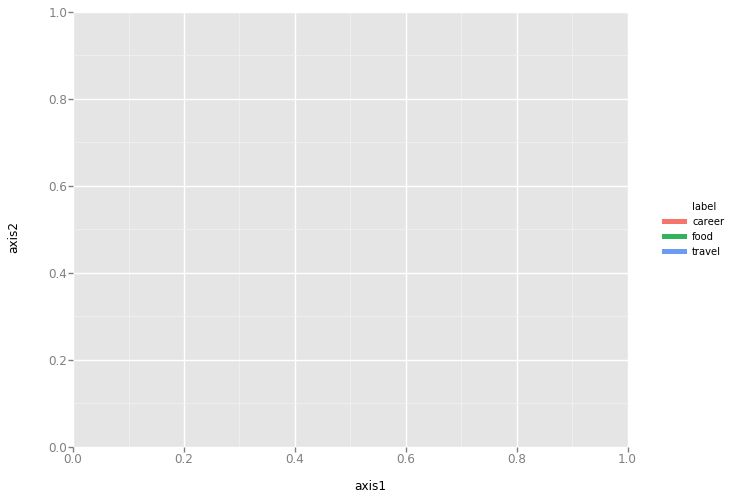

In [49]:
from ggplot import *
myplot = ggplot(aes(x='axis1', y='axis2', color='label'), data=df)  + geom_point()
myplot.save('myplot.png')